In [1]:
import os
import cv2
import numpy as np
import pydicom

def img_to_np(path, size, resize=True):
    img_array = []
#     view_pos = []
    for fname in os.listdir(path):
        dicom = pydicom.dcmread(os.path.join(path, fname))
        img = dicom.pixel_array
        if resize:
            img = cv2.resize(img, size)
        img = img.astype('float32') / 255.
#         img = np.stack((img,) * 3, axis=-1)
        img_array.append(np.asarray(img))
#         view_pos.append(dicom.ViewPosition)
    img_array = np.array(img_array)
#     view_pos = np.array(view_pos)
    return img_array#, view_pos

        
path_train = "../input/rsna-pneumonia-detection-challenge/stage_2_train_images"
path_test = "../input/rsna-pneumonia-detection-challenge/stage_2_test_images"

# train_df = pd.read_csv("../input/chest-xray-anomaly-detection/train.csv")
path_train_sub = "../input/chest-xray-anomaly-detection/images"

# sub_df = pd.read_csv("../input/chest-xray-anomaly-detection/sample_submission.csv")
path_test_sub = "../input/chest-xray-anomaly-detection/images"

output = "./output"

size = (128, 128)
shape = (128, 128, 1)
nrows = 128
# batch = 16

In [2]:
import tensorflow.keras,os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def create_model():
    model = Sequential()
    model.add(Conv2D(input_shape=shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Dense(2, activation='sigmoid'))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(UpSampling2D(size=(2,2)))#,strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(UpSampling2D(size=(2,2)))#,strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(UpSampling2D(size=(2,2)))#,strides=(2,2)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(UpSampling2D(size=(2,2)))#,strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(UpSampling2D(size=(2,2)))#,strides=(2,2)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=1,kernel_size=(3,3),padding="same", activation="relu"))
    
#     autoencoder = keras.Model(input_img, decoded)
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer=opt, loss='mean_squared_error')

    return model

autoencoder = create_model()
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       2

In [3]:
x_train = img_to_np(path_train, size, resize=True)
print(x_train.shape)
x_test = img_to_np(path_test, size, resize=True)
print(x_test.shape)

(26684, 128, 128)
(3000, 128, 128)


In [4]:
from sklearn.model_selection import train_test_split

x_train = np.reshape(x_train, (len(x_train), nrows, nrows, 1))
x_train, x_train_test = train_test_split(x_train, test_size=0.20, random_state=42)
print(x_train.shape)
print(x_train_test.shape)
x_test = np.reshape(x_test, (len(x_test), nrows, nrows, 1))
print(x_test.shape)

(21347, 128, 128, 1)
(5337, 128, 128, 1)
(3000, 128, 128, 1)


In [5]:
from tensorflow.keras.callbacks import *

callbacks = [EarlyStopping(monitor='val_loss', patience=15)]
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(x_train_test, x_train_test),
                callbacks=callbacks)

Epoch 1/100
1335/1335 [==============================] - 124s 93ms/step - loss: 0.0284 - val_loss: 0.0103
Epoch 2/100
1335/1335 [==============================] - 122s 92ms/step - loss: 0.0088 - val_loss: 0.0076
Epoch 3/100
1335/1335 [==============================] - 122s 92ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 4/100
1335/1335 [==============================] - 122s 92ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 5/100
1335/1335 [==============================] - 122s 91ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 6/100
1335/1335 [==============================] - 122s 92ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 7/100
1335/1335 [==============================] - 122s 92ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 8/100
1335/1335 [==============================] - 122s 92ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 9/100
1335/1335 [==============================] - 122s 92ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 10/100
1335/1335 [======================

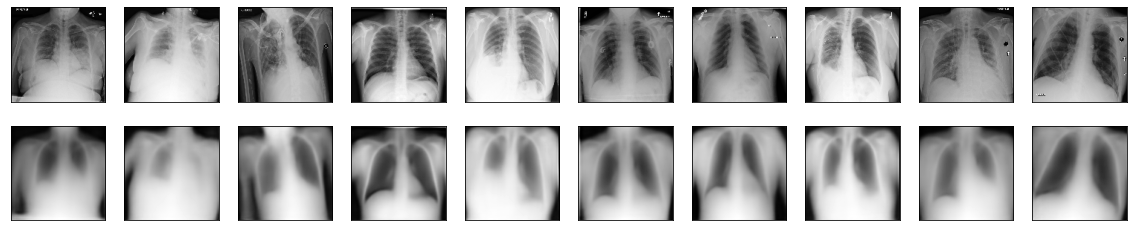

In [6]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(nrows, nrows))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(nrows, nrows))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
import matplotlib.pyplot as plt
import pandas as pd 

def test_to_np(path, size, resize=True, lista=None):
    img_array = []
#     view_pos = []
    if lista is None:
        lista = os.listdir(path)
    for fname in lista:
        color_img = cv2.imread(os.path.join(path, fname))
        img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
        if resize:
            img = cv2.resize(img, size)
        img = img.astype('float32') / 255.
#         img = np.stack((img,) * 3, axis=-1)
        img_array.append(np.asarray(img))
#         view_pos.append(dicom.ViewPosition)
    img_array = np.array(img_array)
#     view_pos = np.array(view_pos)
    return img_array#, view_pos


df_train = pd.read_csv("../input/chest-xray-anomaly-detection/train.csv")
files_train = df_train["fileName"].tolist()
target_train =  df_train["anomaly"].tolist()
test = test_to_np(path_test_sub, size, resize=True, lista=files_train)
print(test.shape)

test = np.reshape(test, (len(test), nrows, nrows, 1))
print(test.shape)

decoded_test = autoencoder.predict(test)



(3919, 128, 128)
(3919, 128, 128, 1)


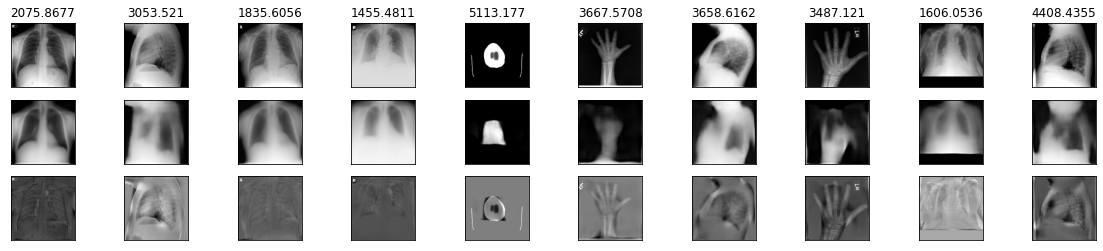

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    #error 
    error = np.sqrt(np.sum(np.power((test[i] * 255) - (decoded_test[i] * 255),2)))
    # Display original
    ax = plt.subplot(3, n, i)
    ax.set_title(error)
    plt.imshow(test[i].reshape(nrows, nrows))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_test[i].reshape(nrows, nrows))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(3, n, (i + n*2))
    plt.imshow((test[i]- decoded_test[i]).reshape(nrows, nrows))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [9]:
print(type(test[0]))
print(np.count_nonzero(test[0] < 10))
print(np.max(test[0]))
print(np.max(decoded_test[0]))

<class 'numpy.ndarray'>
16384
1.0
1.0179808


In [10]:
result = []
whites = []
for real, decoded in zip(test, decoded_test):
    real = real * 255
    decoded = decoded * 255
    white_count = np.count_nonzero(real > 50)
    error = np.sqrt(np.sum(np.power(real - decoded,2)))
    whites.append(white_count)
    result.append(error)

In [11]:
result = np.array(result)
target_train = np.array(target_train)
result_0 = result[target_train == 0]
result_1 = result[target_train == 1]


In [12]:
whites = np.array(whites)
whites_0 = whites[target_train == 0]
whites_1 = whites[target_train == 1]

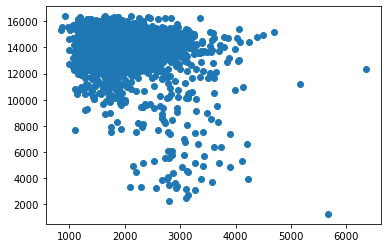

In [13]:
plt.scatter(result_0, whites_0)
plt.show()

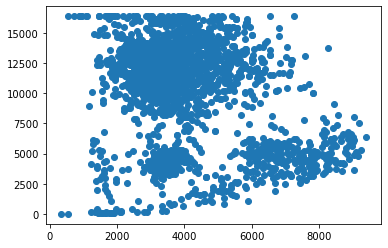

In [14]:
plt.scatter(result_1, whites_1)
plt.show()

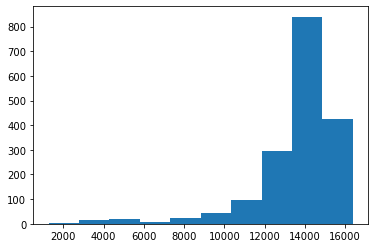

In [15]:
plt.hist(whites_0)
plt.show()

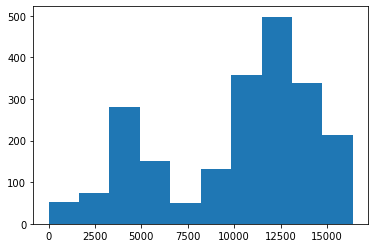

In [16]:
plt.hist(whites_1)
plt.show()

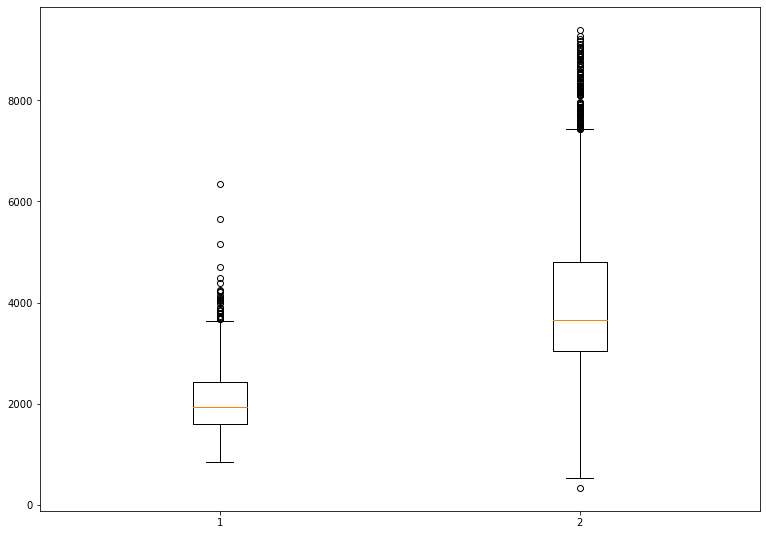

In [17]:
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1]) 
bp = ax.boxplot([result_0, result_1]) 
plt.show() 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


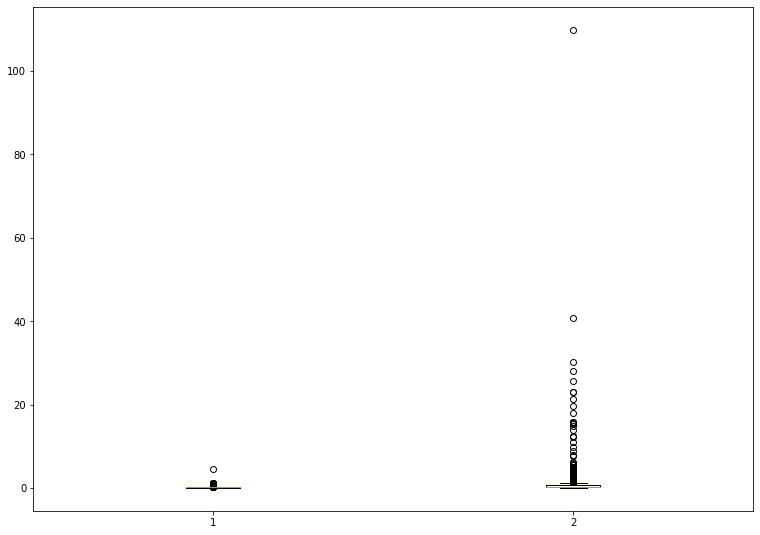

In [18]:
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1]) 
bp = ax.boxplot([result_0 / whites_0, result_1 / whites_1]) 
plt.show() 

# Submission

(9145, 128, 128)
(9145, 128, 128, 1)


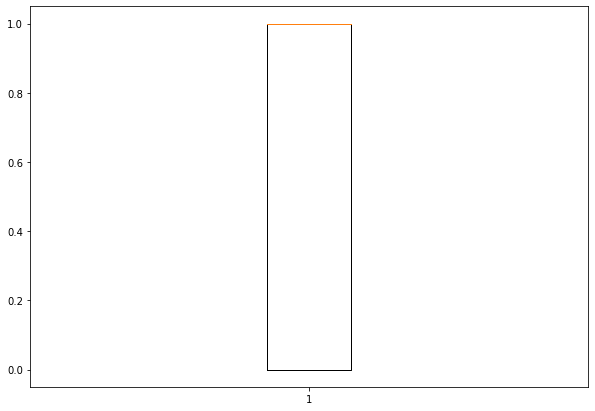

In [19]:
df_test = pd.read_csv("../input/chest-xray-anomaly-detection/sample_submission.csv")
files_test = df_test["fileName"].tolist()
sub = test_to_np(path_test_sub, size, resize=True, lista=files_test)
print(sub.shape)

sub = np.reshape(sub, (len(sub), nrows, nrows, 1))
print(sub.shape)

decoded_sub = autoencoder.predict(sub)


result_sub = []
os.mkdir("./result")
for real, decoded, file in zip(sub, decoded_sub, files_test):
    real = real * 255
    decoded = decoded * 255
    error = np.sqrt(np.sum(np.power(real - decoded,2)))
    white_count = np.count_nonzero(real > 50)
    error = 0 if error <= 2800 and white_count > 8000 else 1
    result_sub.append(error)
#     cv2.imwrite(os.path.join("./result",f"{int(error)}__{file}"), decoded)
    

results=pd.DataFrame({"fileName":files_test,
                      "anomaly": result_sub})
results.to_csv("results.csv",index=False)

fig = plt.figure(figsize =(10, 7)) 
plt.boxplot(result_sub) 
plt.show() 

In [20]:
# import shutil
# shutil.make_archive("./res.zip", 'zip', "./result")